In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

<h5 style="color: SkyBlue;">Load Dataset</h5>

In [19]:
df = pd.read_csv('user_data_for_disease_prediction - unclassified data set.csv')
print(df.head())

   Heart Rate (bpm)  Breathing Rate (brpm)  Oxygen Saturation (%)  \
0              80.3                   12.2                   96.4   
1              73.1                   17.7                   95.9   
2              72.2                   18.0                   96.0   
3              70.6                   14.7                   95.1   
4              99.5                   19.5                   97.6   

   Blood Pressure (systolic)  Blood Pressure (diastolic)  Stress Index  \
0                      107.3                        74.2          39.6   
1                       92.4                        70.8          98.7   
2                      102.4                        75.6          45.3   
3                      110.0                        62.2          77.8   
4                      110.2                        73.0          57.3   

   Recovery Ability  PNS Index  SNS Index  RMSSD (ms)  SD2 (ms)  \
0                 0       -0.9        0.4        49.7      67.9   
1     

In [20]:
# handle missing values 
df.fillna(0, inplace=True)

In [30]:
def detect_cardiovascular(row):
    gender = row['Gender (0-M;1-F)']
    return int(
        70 <= row['Heart Rate (bpm)'] <= 80 and 
        row['Blood Pressure (systolic)'] >= 140 and 
        row['Blood Pressure (diastolic)'] >= 90 and
        row['Oxygen Saturation (%)'] < 90 and
        1.22 <= row['Stress Index'] <= 4.53 and 
        row['HRV SDNN (ms)'] < 50 and
        (row['Hemoglobin (g/dl)'] < 13 if gender == 0 else row['Hemoglobin (g/dl)'] < 12) or
        row['Hemoglobin A1c (%)'] >= 6.5
    )

def detect_respiratory(row):
    return int(
        row['Breathing Rate (brpm)'] > 15 and 
        row['Oxygen Saturation (%)'] < 88 and
        row['Heart Rate (bpm)'] > 80 and
        row['Stress Index'] < 0.7 
    )

def detect_cfs(row):
    rmssd_low = row['RMSSD (ms)'] < 25
    sd1_low = row['SD1 (ms)'] < 30
    recovery_low = row['Recovery Ability'] < 60
    mean_rri_low = row['Mean RRI (ms)'] < 800

    return int(rmssd_low and sd1_low and recovery_low and mean_rri_low)

def detect_arrhythmia(row):
    return int(
        row['Heart Rate (bpm)'] > 120 or row['Heart Rate (bpm)'] < 50 and
        row['RMSSD (ms)'] < 20 and 
        row['SD2 (ms)'] < 70 and
        row['HRV SDNN (ms)'] < 50 
        # row['LF/HF'] > 2.0
    )

def detect_diabetes(row):
    return int(
        row['Hemoglobin A1c (%)'] >= 6.5 and
        row['Hemoglobin (g/dl)'] < 12
    )

def detect_hypertension(row):
    gender = row['Gender (0-M;1-F)']
    heart_rate_high = row['Heart Rate (bpm)'] > 80
    hba1c_high = row['Hemoglobin A1c (%)'] >= 6.5
    hrv_sdnn_low = row['HRV SDNN (ms)'] < 100

    # Hemoglobin thresholds based on gender
    if gender == 0:  # Male
        hemoglobin_abnormal = not (13.8 <= row['Hemoglobin (g/dl)'] <= 17.2)
    else:  # Female
        hemoglobin_abnormal = not (12.1 <= row['Hemoglobin (g/dl)'] <= 15.1)

    return int(heart_rate_high and hba1c_high and hrv_sdnn_low and hemoglobin_abnormal)

def detect_anaemia(row):
    gender = row['Gender (0-M;1-F)']
    return int(
        row['Heart Rate (bpm)'] > 100 and
        (row['Hemoglobin (g/dl)'] < 13 if gender else row['Hemoglobin (g/dl)'] < 12) and 
        row['RMSSD (ms)'] < 20 and
        row['SD2 (ms)'] < 50  
        # row['LF/HF'] > 2.5
    )

def detect_atherosclerosis(row):
    return int(
        row['Heart Rate (bpm)'] > 100 and
        row['Hemoglobin A1c (%)'] > 6.5 and
        row['RMSSD (ms)'] < 20 
        # row['LF/HF'] > 2.5
    )

def detect_autonomic_dysfunction(row):
    return int(
        row['Heart Rate (bpm)'] > 100 and
        row['SD1 (ms)'] < 20 and
        row['RMSSD (ms)'] < 20 and 
        row['HRV SDNN (ms)'] < 50
    )

def detect_stress_related_disorder(row):
    gender = row.get('Gender (0-M;1-F)')
    return int(
        # row['LF/HF'] > 2.5 or 
        row['Hemoglobin A1c (%)'] > 6.5
    )

df['Cardiovascular'] = df.apply(detect_cardiovascular, axis=1)
df['Respiratory'] = df.apply(detect_respiratory, axis=1)
df['CFS'] = df.apply(detect_cfs, axis=1)
df['Arrhythmia'] = df.apply(detect_arrhythmia, axis=1)
df['Diabetes'] = df.apply(detect_diabetes, axis=1)
df['Hypertension'] = df.apply(detect_hypertension, axis=1)
df['Anaemia'] = df.apply(detect_anaemia, axis=1)
df['Atherosclerosis'] = df.apply(detect_atherosclerosis, axis=1)
df['Autonomic Dysfunction'] = df.apply(detect_autonomic_dysfunction, axis=1)
df['Stress Related Disorder'] = df.apply(detect_stress_related_disorder, axis=1)

disease_list = ['Cardiovascular', 'Respiratory', 'CFS', 'Arrhythmia', 'Diabetes',
                  'Hypertension', 'Anaemia', 'Atherosclerosis', 
                  'Autonomic Dysfunction', 'Stress Related Disorder']

classification_reports = {}
accuracy_scores = {}
all_y_true = []
all_y_pred = []

<h5 style="color: SkyBlue;">Ranking of diseases in the dataset</h5>

In [25]:
disease_counts = df[['Cardiovascular', 'Respiratory', 'CFS', 'Arrhythmia', 
                     'Diabetes', 'Hypertension', 'Anaemia', 'Atherosclerosis', 
                     'Autonomic Dysfunction', 'Stress Related Disorder']].sum()

print("Disease Counts:\n", disease_counts)

Disease Counts:
 Cardiovascular             182427
Respiratory                     0
CFS                             0
Arrhythmia                 116990
Diabetes                    91954
Hypertension               107674
Anaemia                     26066
Atherosclerosis             23339
Autonomic Dysfunction           0
Stress Related Disorder    173370
dtype: int64


<h5 style="color: SkyBlue;">Logistic Regression</h5>

c:\Users\zen\Documents\les trucs du boulot\TM R&D\E-Health\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Using DummyClassifier for Respiratory (only one class: [0])
Using DummyClassifier for CFS (only one class: [0])


c:\Users\zen\Documents\les trucs du boulot\TM R&D\E-Health\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\zen\Documents\les trucs du boulot\TM R&D\E-Health\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

Using DummyClassifier for Autonomic Dysfunction (only one class: [0])


c:\Users\zen\Documents\les trucs du boulot\TM R&D\E-Health\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                   Disease  Precision    Recall  F1-score  Accuracy
0           Cardiovascular   0.945675  0.936106  0.940866  0.952298
1              Respiratory   0.000000  0.000000  0.000000  1.000000
2                      CFS   0.000000  0.000000  0.000000  1.000000
3               Arrhythmia   0.855629  0.868450  0.861992  0.927704
4                 Diabetes   0.829840  0.788264  0.808518  0.923704
5             Hypertension   0.736401  0.668899  0.701029  0.863484
6                  Anaemia   0.751813  0.604542  0.670182  0.965533
7          Atherosclerosis   0.777985  0.678050  0.724588  0.973267
8    Autonomic Dysfunction   0.000000  0.000000  0.000000  1.000000
9  Stress Related Disorder   0.955946  0.949611  0.952768  0.963727


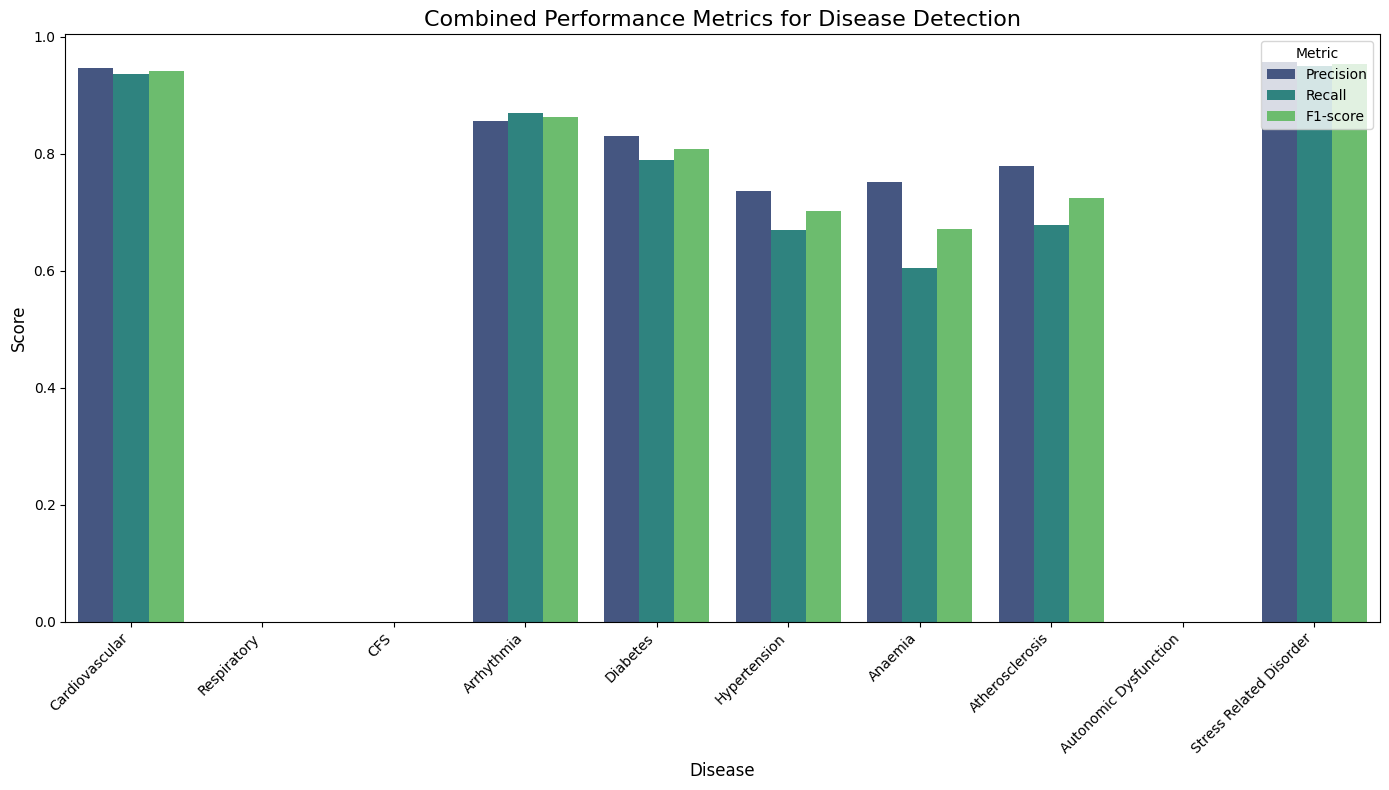

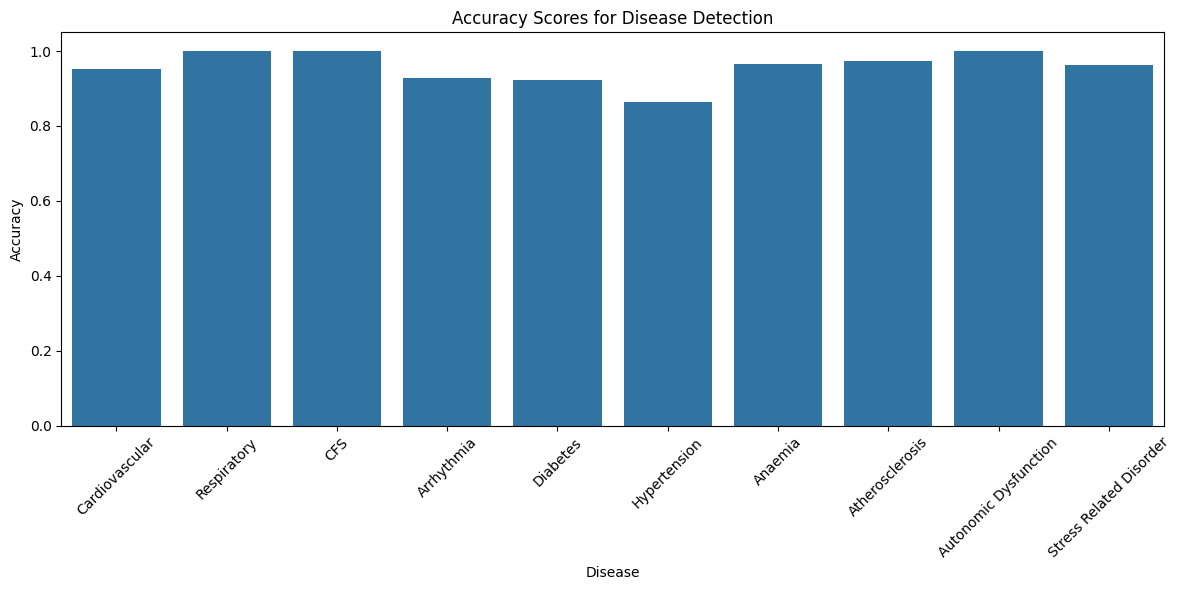

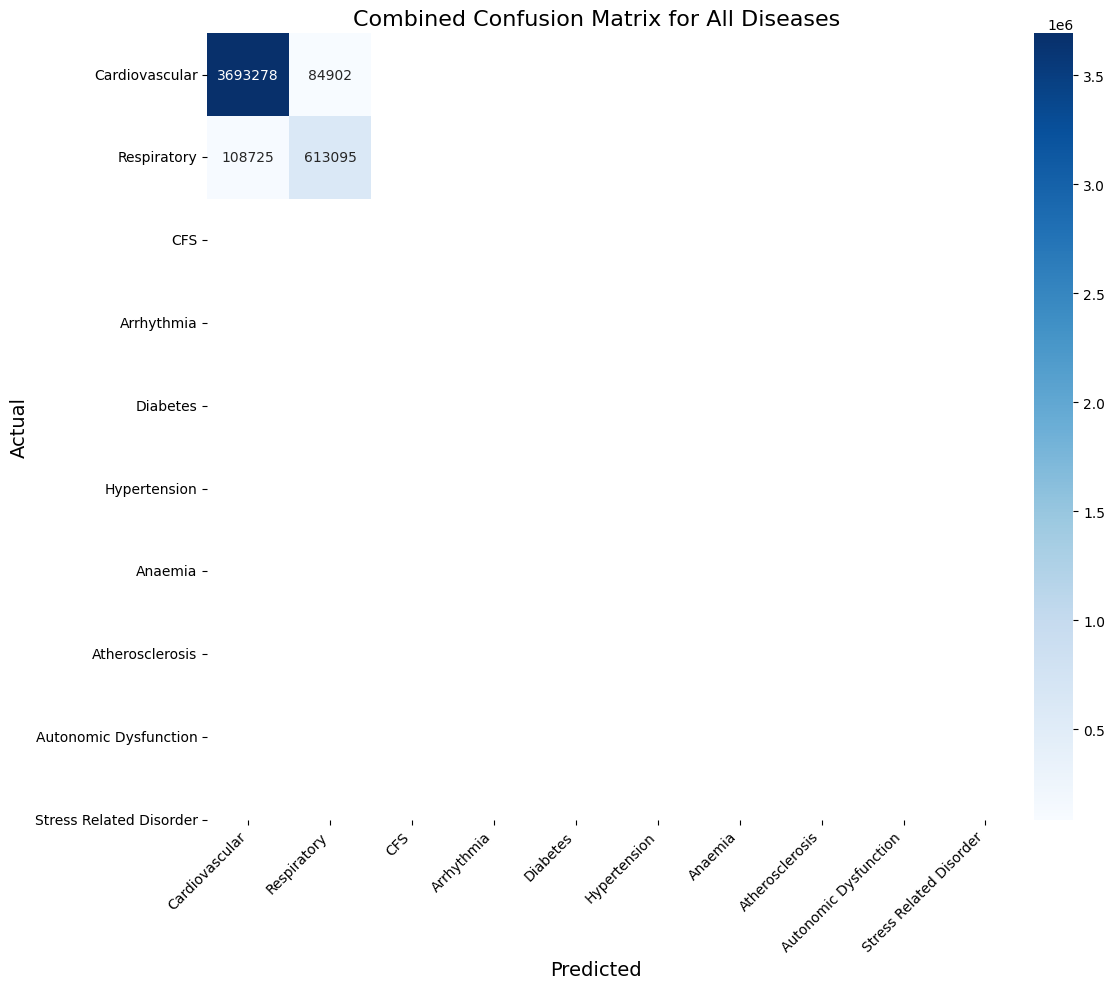

In [26]:
def train_logistic_regression(X, y, disease_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    classification_reports[disease_name] = classification_report(y_test, y_pred, output_dict=True)
    accuracy_scores[disease_name] = accuracy_score(y_test, y_pred)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

X = df.drop(['Cardiovascular', 'Respiratory', 'CFS', 'Arrhythmia', 'Diabetes',
             'Hypertension', 'Anaemia', 'Atherosclerosis', 'Autonomic Dysfunction',
             'Stress Related Disorder'], axis=1)

for disease in ['Cardiovascular', 'Respiratory', 'CFS', 'Arrhythmia', 'Diabetes',
                'Hypertension', 'Anaemia', 'Atherosclerosis', 'Autonomic Dysfunction',
                'Stress Related Disorder']:
    
    y = df[disease] 

    if len(y.unique()) < 2:  # single-class case
        print(f"Using DummyClassifier for {disease} (only one class: {y.unique()})")
        model = DummyClassifier(strategy='most_frequent')
    else:
        model = LogisticRegression(max_iter=1000)  # standard logistic regression for two-class cases

    model.fit(X, y)  # Train the model (or dummy classifier)

    y_pred = model.predict(X)
    
    all_y_true.extend(y.tolist()) 
    all_y_pred.extend(y_pred.tolist())  
    
    # metrics
    report = classification_report(y, y_pred, output_dict=True)
    accuracy = accuracy_score(y, y_pred)

    classification_reports[disease] = report
    accuracy_scores[disease] = accuracy

results_list = []

for disease, report in classification_reports.items():
    precision = report.get('1', {}).get('precision', 0.0)  # Default to 0.0 if '1' class is missing
    recall = report.get('1', {}).get('recall', 0.0)
    f1_score = report.get('1', {}).get('f1-score', 0.0)
    accuracy = accuracy_scores[disease]

    results_list.append({
        'Disease': disease,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1_score,
        'Accuracy': accuracy
    })

combined_results = pd.DataFrame(results_list)

print(combined_results)

plt.figure(figsize=(14, 8))
sns.barplot(data=combined_results.melt(id_vars='Disease', value_vars=['Precision', 'Recall', 'F1-score']),
            x='Disease', y='value', hue='variable', palette='viridis')
plt.title('Combined Performance Metrics for Disease Detection', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Disease', fontsize=12)
plt.legend(title='Metric', loc='upper right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=combined_results['Disease'], y=combined_results['Accuracy'])
plt.title('Accuracy Scores for Disease Detection')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

confusion_mcombo = confusion_matrix(all_y_true, all_y_pred)
# combined confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_mcombo, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cardiovascular', 'Respiratory', 'CFS', 'Arrhythmia', 
                         'Diabetes', 'Hypertension', 'Anaemia', 'Atherosclerosis', 
                         'Autonomic Dysfunction', 'Stress Related Disorder'],
            yticklabels=['Cardiovascular', 'Respiratory', 'CFS', 'Arrhythmia', 
                         'Diabetes', 'Hypertension', 'Anaemia', 'Atherosclerosis', 
                         'Autonomic Dysfunction', 'Stress Related Disorder'])
plt.title('Combined Confusion Matrix for All Diseases', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() 
plt.show()

<h5 style="color: SkyBlue;">GBM</h5>

Using DummyClassifier for Respiratory (only one class: [0])
Using DummyClassifier for CFS (only one class: [0])
Using DummyClassifier for Autonomic Dysfunction (only one class: [0])
                   Disease  Precision  Recall  F1-score  Accuracy
0           Cardiovascular        1.0     1.0       1.0       1.0
1               Arrhythmia        1.0     1.0       1.0       1.0
2                 Diabetes        1.0     1.0       1.0       1.0
3             Hypertension        1.0     1.0       1.0       1.0
4                  Anaemia        1.0     1.0       1.0       1.0
5          Atherosclerosis        1.0     1.0       1.0       1.0
6  Stress Related Disorder        1.0     1.0       1.0       1.0


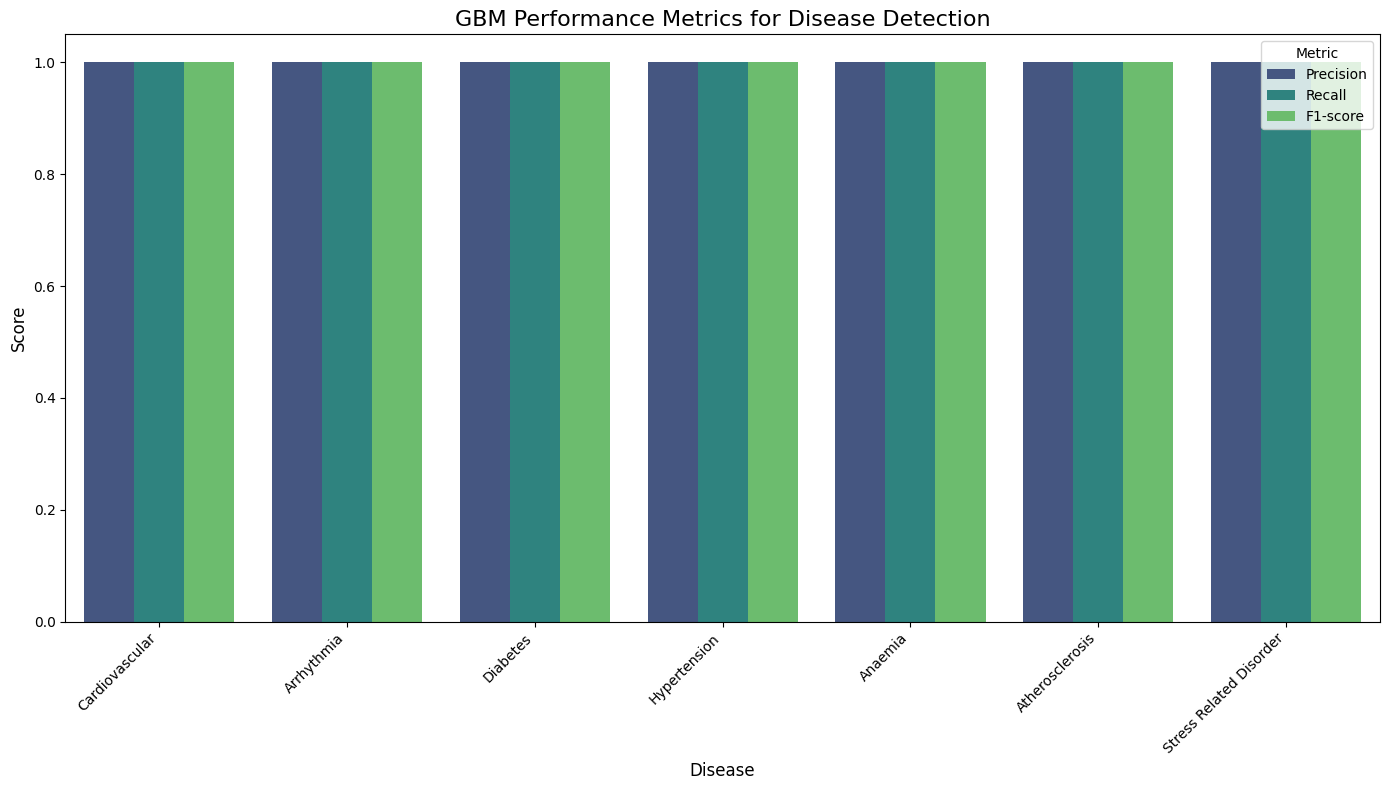

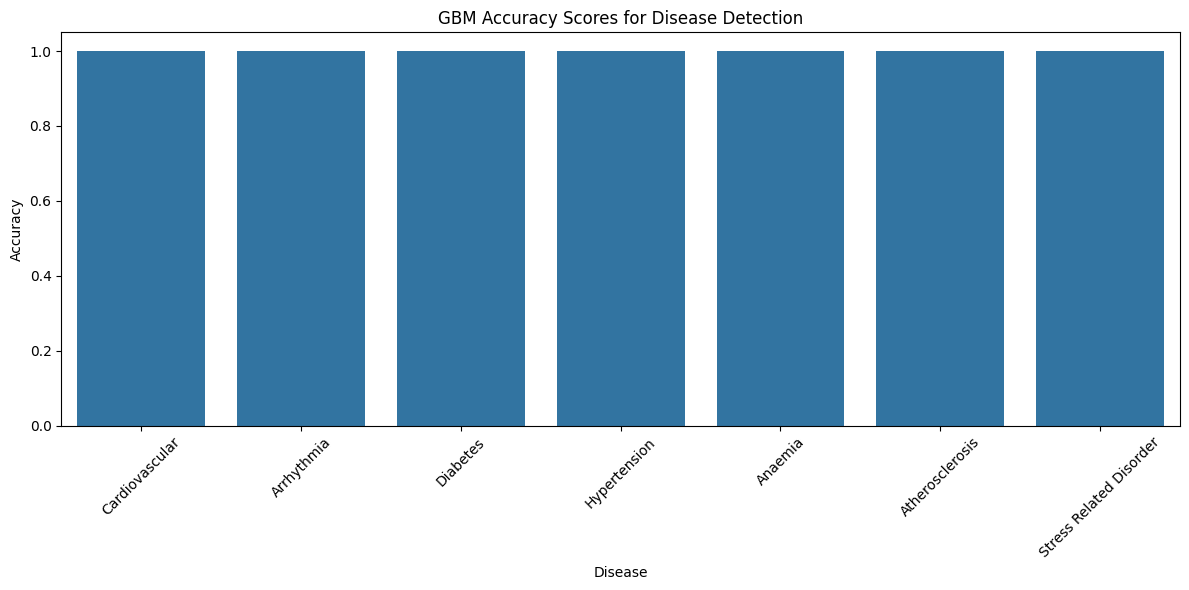

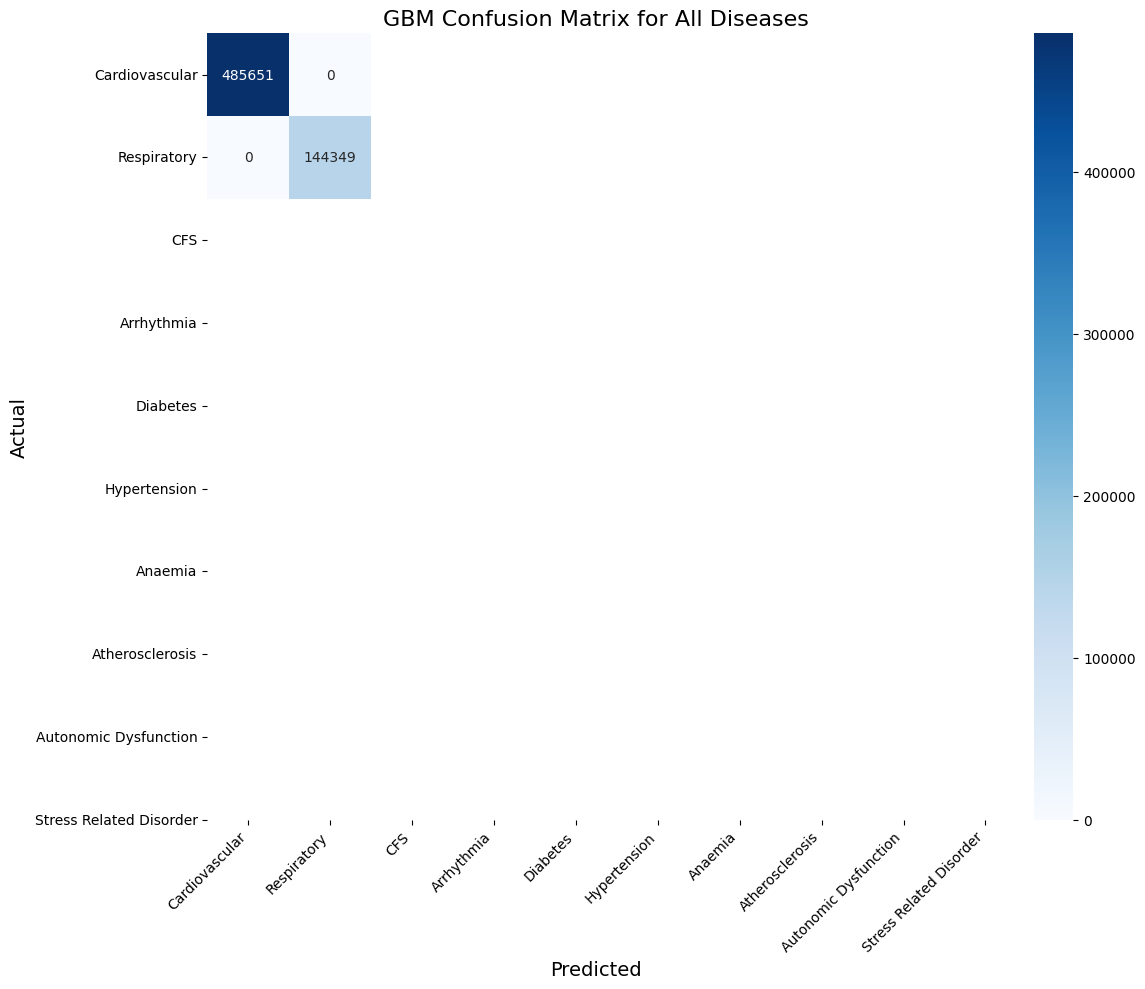

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

def train_gbm(X, y, disease_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = GradientBoostingClassifier()  # Use GBM with balanced class weights
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    classification_reports[disease_name] = classification_report(y_test, y_pred, output_dict=True)
    accuracy_scores[disease_name] = accuracy_score(y_test, y_pred)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

for disease in disease_list:
    
    y = df[disease]
    
    if len(y.unique()) < 2:  # single-class case
        print(f"Using DummyClassifier for {disease} (only one class: {y.unique()})")
        model = DummyClassifier(strategy='most_frequent')
    else:
        train_gbm(X, y, disease)

results_list_gbm = []

for disease, report in classification_reports.items():
    precision = report.get('1', {}).get('precision', 0.0)
    recall = report.get('1', {}).get('recall', 0.0)
    f1_score = report.get('1', {}).get('f1-score', 0.0)
    accuracy = accuracy_scores[disease]

    results_list_gbm.append({
        'Disease': disease,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1_score,
        'Accuracy': accuracy
    })

combined_results_gbm = pd.DataFrame(results_list_gbm)

print(combined_results_gbm)

plt.figure(figsize=(14, 8))
sns.barplot(data=combined_results_gbm.melt(id_vars='Disease', value_vars=['Precision', 'Recall', 'F1-score']),
            x='Disease', y='value', hue='variable', palette='viridis')
plt.title('GBM Performance Metrics for Disease Detection', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Disease', fontsize=12)
plt.legend(title='Metric', loc='upper right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=combined_results_gbm['Disease'], y=combined_results_gbm['Accuracy'])
plt.title('GBM Accuracy Scores for Disease Detection')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

confusion_mgbm = confusion_matrix(all_y_true, all_y_pred)
# combined confusion matrix for GBM
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_mgbm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=disease_list,
            yticklabels=disease_list)
plt.title('GBM Confusion Matrix for All Diseases', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() 
plt.show()

<h5 style="color: SkyBlue;">KNN</h5>

Using DummyClassifier for Respiratory (only one class: [0])
Using DummyClassifier for CFS (only one class: [0])
Using DummyClassifier for Autonomic Dysfunction (only one class: [0])
                   Disease  Precision    Recall  F1-score  Accuracy
0           Cardiovascular   0.501015  0.459718  0.479479  0.595000
1               Arrhythmia   0.900467  0.896472  0.898465  0.947744
2                 Diabetes   0.429512  0.218978  0.290070  0.780111
3             Hypertension   0.421740  0.268378  0.328019  0.735411
4                  Anaemia   0.484507  0.134454  0.210494  0.942656
5          Atherosclerosis   0.343750  0.049914  0.087170  0.946244
6  Stress Related Disorder   0.486762  0.425279  0.453948  0.604889


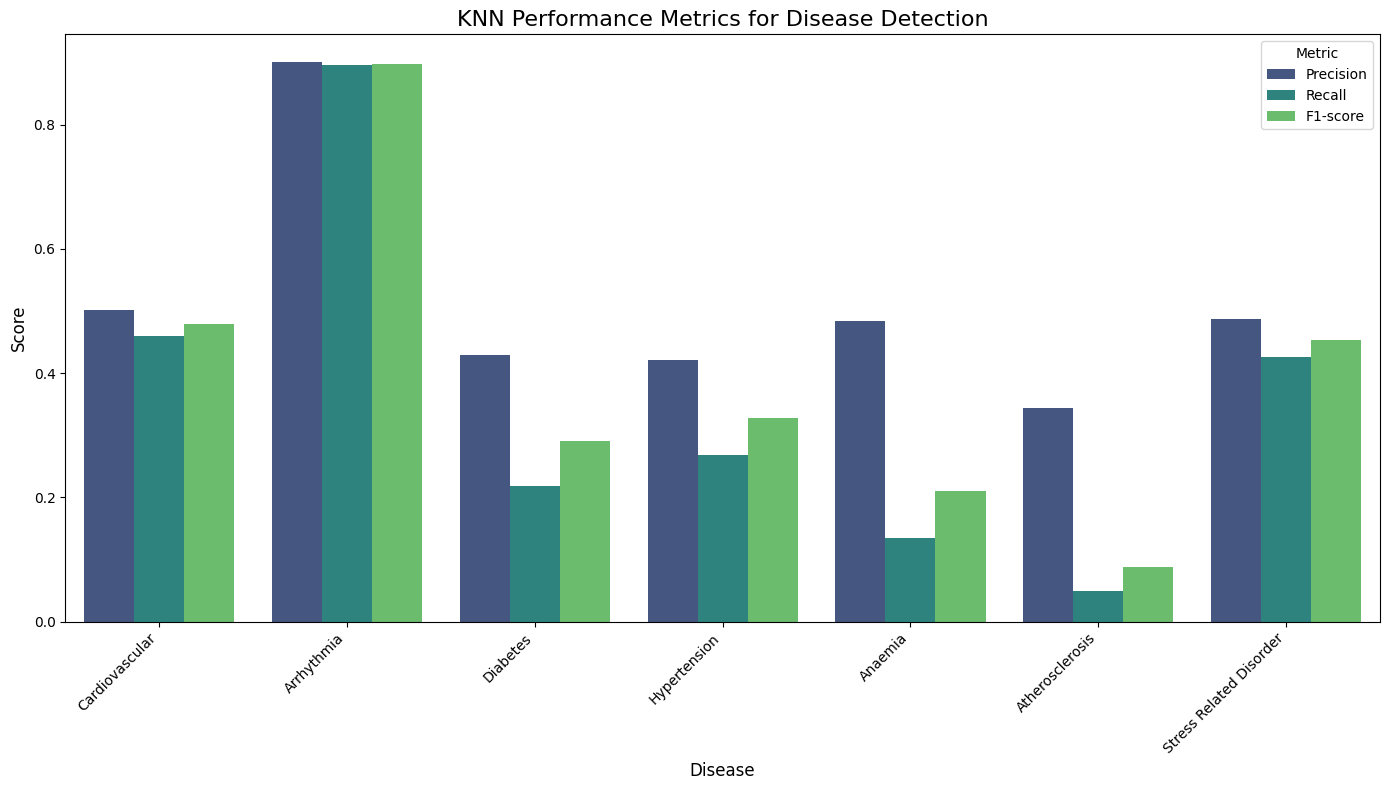

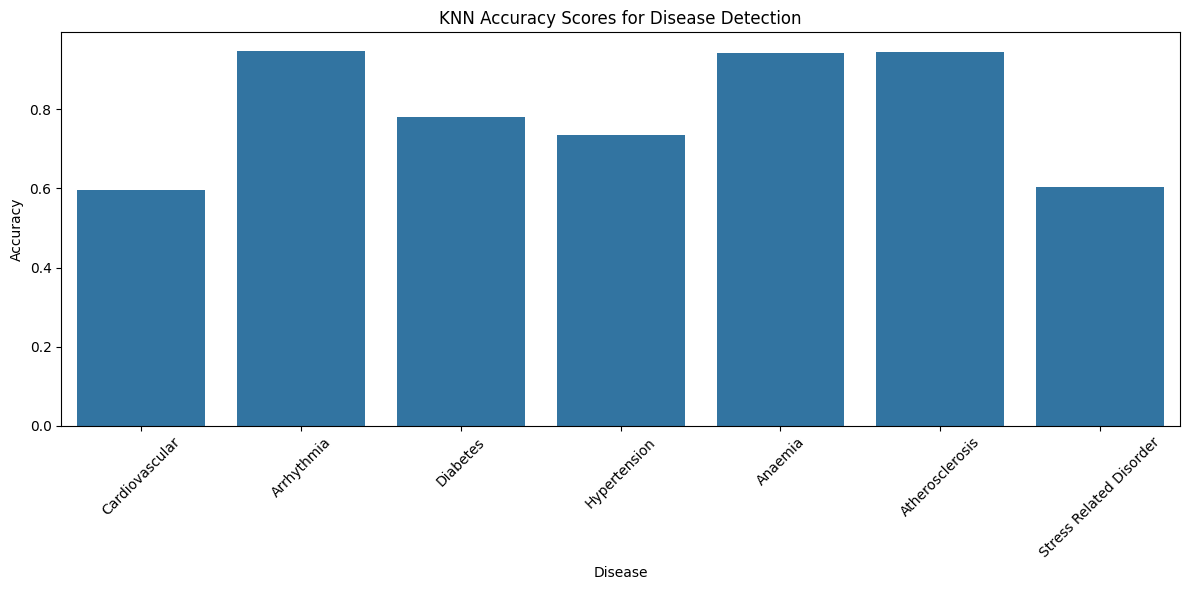

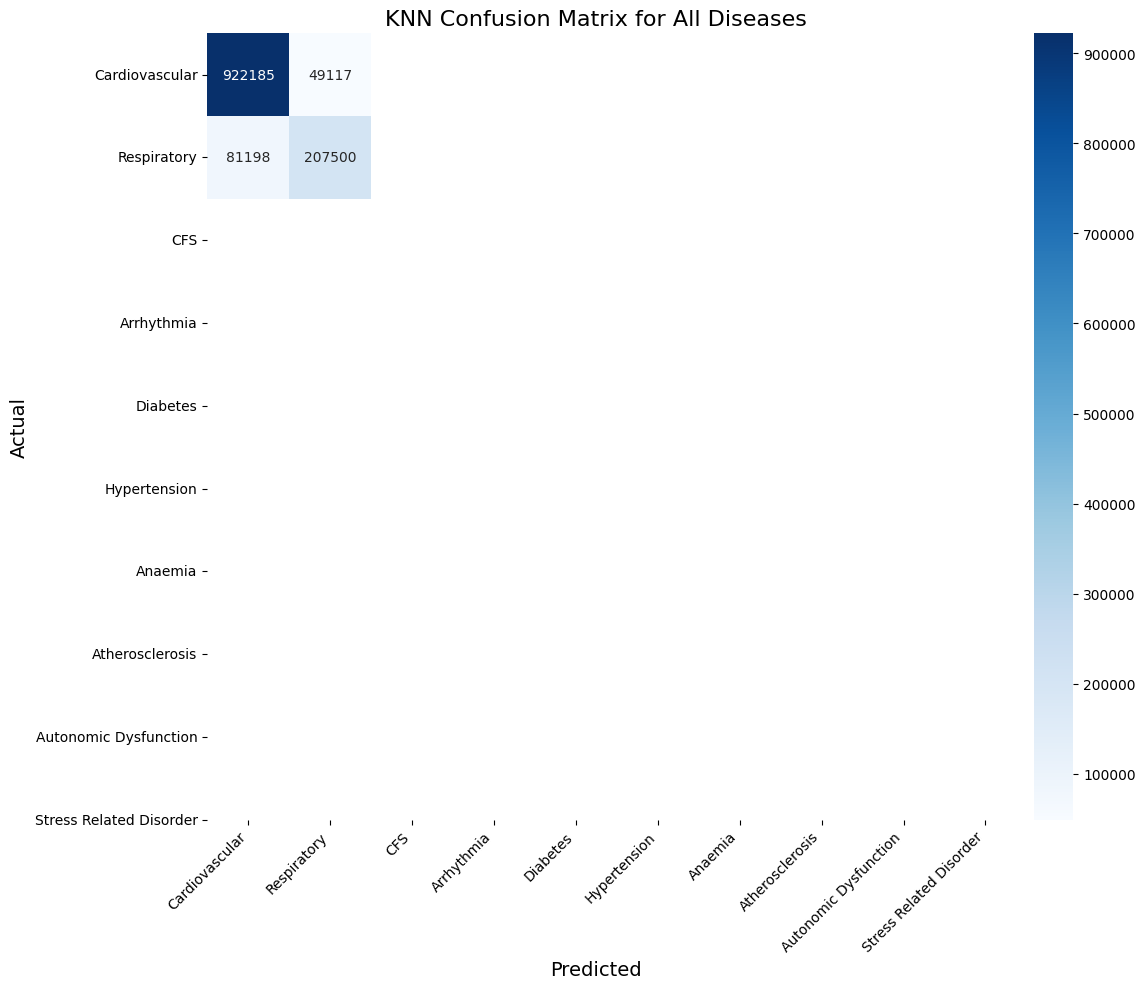

In [32]:
def train_knn(X, y, disease_name, n_neighbors=5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    classification_reports[disease_name] = classification_report(y_test, y_pred, output_dict=True)
    accuracy_scores[disease_name] = accuracy_score(y_test, y_pred)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

for disease in disease_list:
    
    y = df[disease]

    if len(y.unique()) < 2:  # single-class case
        print(f"Using DummyClassifier for {disease} (only one class: {y.unique()})")
        model = DummyClassifier(strategy='most_frequent')
    else:
        train_knn(X, y, disease)

results_list = []
for disease, report in classification_reports.items():
    precision = report.get('1', {}).get('precision', 0.0)
    recall = report.get('1', {}).get('recall', 0.0)
    f1_score = report.get('1', {}).get('f1-score', 0.0)
    accuracy = accuracy_scores[disease]

    results_list.append({
        'Disease': disease,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1_score,
        'Accuracy': accuracy
    })

combined_results_knn = pd.DataFrame(results_list)
print(combined_results_knn)

plt.figure(figsize=(14, 8))
sns.barplot(data=combined_results_knn.melt(id_vars='Disease', value_vars=['Precision', 'Recall', 'F1-score']),
            x='Disease', y='value', hue='variable', palette='viridis')
plt.title('KNN Performance Metrics for Disease Detection', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Disease', fontsize=12)
plt.legend(title='Metric', loc='upper right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=combined_results_knn['Disease'], y=combined_results_knn['Accuracy'])
plt.title('KNN Accuracy Scores for Disease Detection')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

confusion_mknn = confusion_matrix(all_y_true, all_y_pred)
# combined confusion matrix for KNN
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_mknn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=disease_list,
            yticklabels=disease_list)
plt.title('KNN Confusion Matrix for All Diseases', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() 
plt.show()

<h5 style="color: SkyBlue;">XGBoost</h5>

c:\Users\zen\Documents\les trucs du boulot\TM R&D\E-Health\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:08:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Using DummyClassifier for Respiratory (only one class: [0])
Using DummyClassifier for CFS (only one class: [0])


c:\Users\zen\Documents\les trucs du boulot\TM R&D\E-Health\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:08:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\zen\Documents\les trucs du boulot\TM R&D\E-Health\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:08:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\zen\Documents\les trucs du boulot\TM R&D\E-Health\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:08:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameter

Using DummyClassifier for Autonomic Dysfunction (only one class: [0])


c:\Users\zen\Documents\les trucs du boulot\TM R&D\E-Health\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:08:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                   Disease  Precision    Recall  F1-score  Accuracy
0           Cardiovascular   1.000000  1.000000  1.000000  1.000000
1               Arrhythmia   0.996980  0.995519  0.996249  0.998067
2                 Diabetes   1.000000  1.000000  1.000000  1.000000
3             Hypertension   0.999538  0.999030  0.999284  0.999656
4                  Anaemia   0.998050  1.000000  0.999024  0.999889
5          Atherosclerosis   1.000000  1.000000  1.000000  1.000000
6  Stress Related Disorder   1.000000  1.000000  1.000000  1.000000


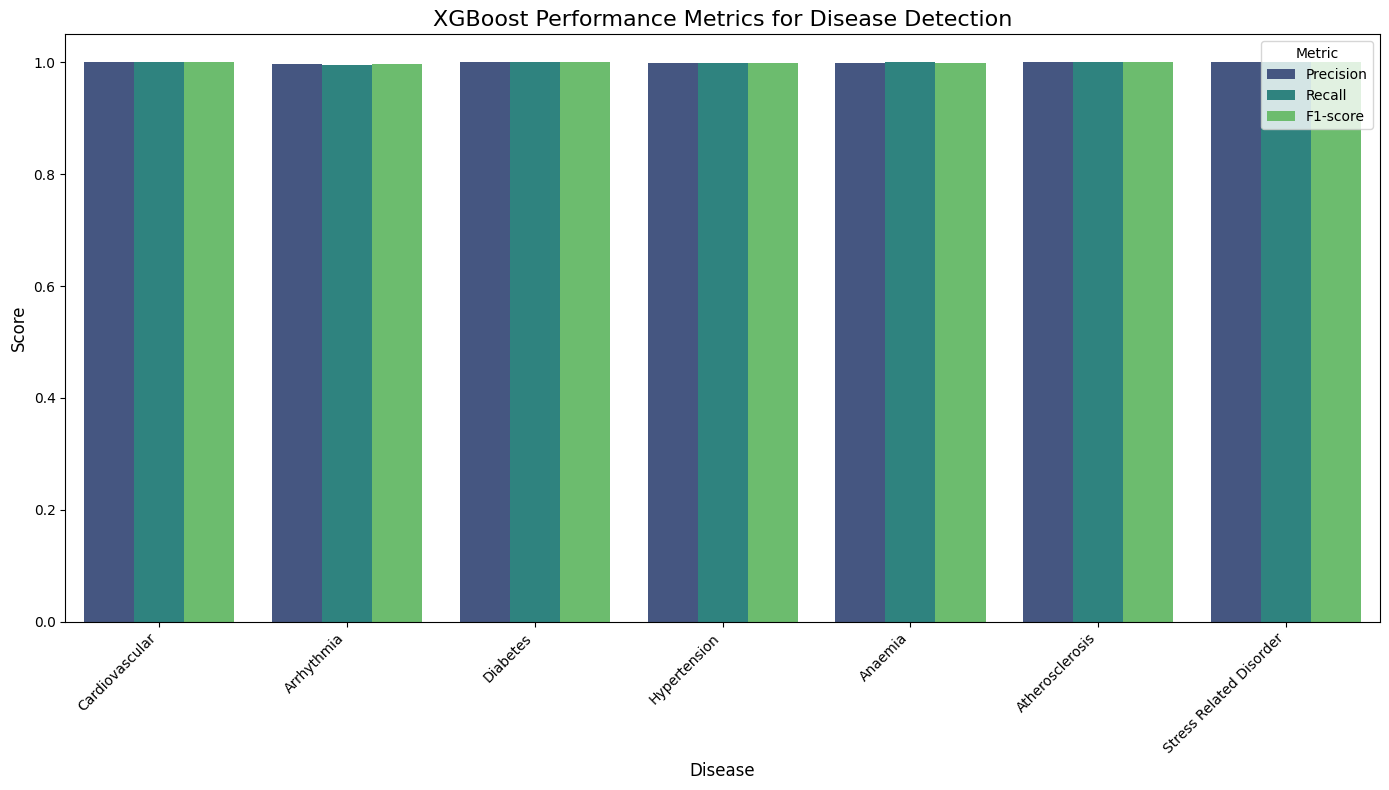

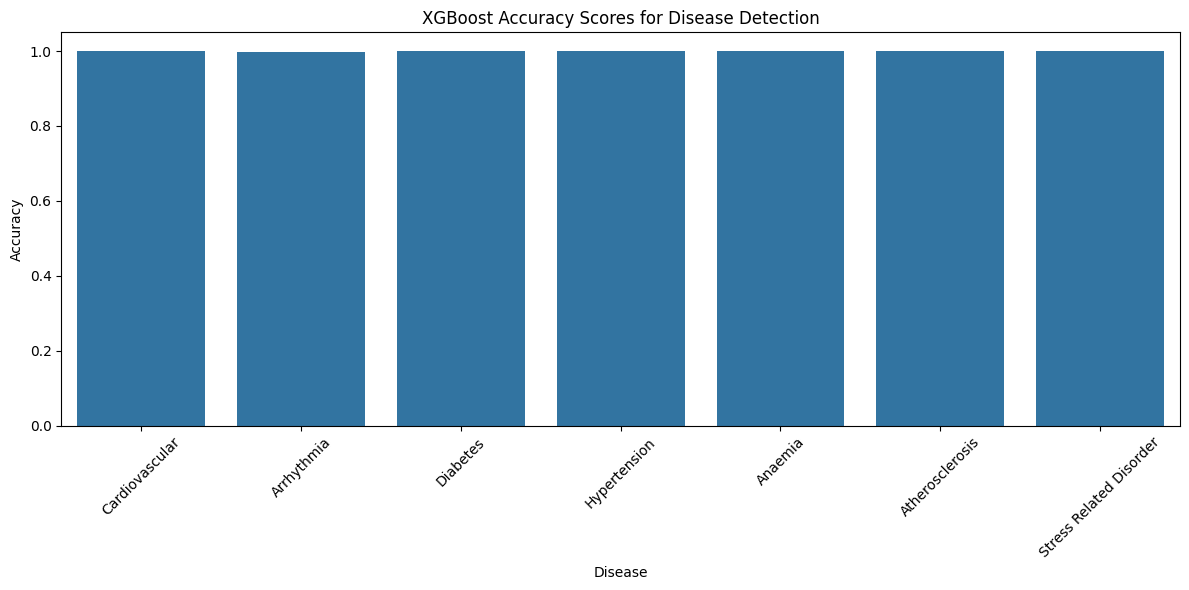

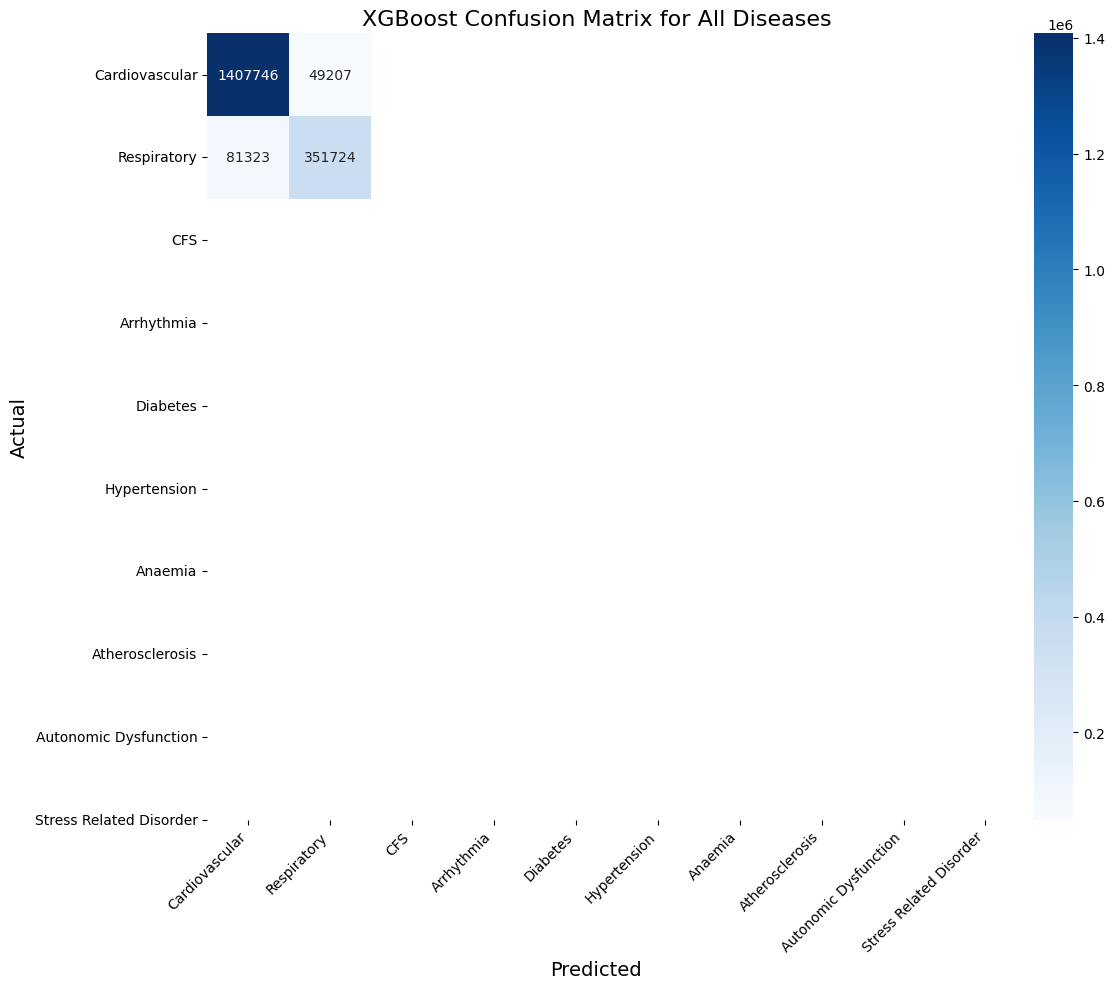

In [33]:
from xgboost import XGBClassifier 

def train_xgboost(X, y, disease_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    classification_reports[disease_name] = classification_report(y_test, y_pred, output_dict=True)
    accuracy_scores[disease_name] = accuracy_score(y_test, y_pred)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

for disease in disease_list:
    
    y = df[disease]

    if len(y.unique()) < 2:  # single-class case
        print(f"Using DummyClassifier for {disease} (only one class: {y.unique()})")
        model = DummyClassifier(strategy='most_frequent')
    else:
        train_xgboost(X, y, disease)

results_list = []
for disease, report in classification_reports.items():
    precision = report.get('1', {}).get('precision', 0.0)
    recall = report.get('1', {}).get('recall', 0.0)
    f1_score = report.get('1', {}).get('f1-score', 0.0)
    accuracy = accuracy_scores[disease]

    results_list.append({
        'Disease': disease,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1_score,
        'Accuracy': accuracy
    })

combined_results_xgboost = pd.DataFrame(results_list)
print(combined_results_xgboost)

plt.figure(figsize=(14, 8))
sns.barplot(data=combined_results_xgboost.melt(id_vars='Disease', value_vars=['Precision', 'Recall', 'F1-score']),
            x='Disease', y='value', hue='variable', palette='viridis')
plt.title('XGBoost Performance Metrics for Disease Detection', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Disease', fontsize=12)
plt.legend(title='Metric', loc='upper right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=combined_results_xgboost['Disease'], y=combined_results_xgboost['Accuracy'])
plt.title('XGBoost Accuracy Scores for Disease Detection')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

# Confusion Matrix Visualization
confusion_mxgboost = confusion_matrix(all_y_true, all_y_pred)
# Combined confusion matrix for XGBoost
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_mxgboost, annot=True, fmt='d', cmap='Blues', 
            xticklabels=disease_list,
            yticklabels=disease_list)
plt.title('XGBoost Confusion Matrix for All Diseases', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() 
plt.show()